## Data pre-preparation code 
this notebook is mainly used for data preparation... 
main goal is to be reproducible for the main notebook!

## Input parameters for the calculations
The below settings how players will be included or excluded based on their games history as well as what it the minumum number of games for a country to be used in the geographical analysis

In [1]:
minimum_years_seen = 1  #number of years a player has to have games for analysis
minimum_games = 10 #number of games a player has to have across all the years seen
minimum_games_country = 50 #number of games for a country to be displayed in the geographical analysis

#if set to true only samples will be loaded not the full datasets
testmode = False

#if set to true precalculated data will be loaded from the saved files
use_prepared_data = False

#if true, when not using generated data interim results will be saved
#please note, when doing precalculation data will only be saved locally
save_prepared_data = False

# if true the files will be read / grabbed from the urls - second and third items in the file name lists
# otherwise local sources will be read - source files need to be in the same directory as the notebook
use_urls = True

## Constants, helpers and other functions
This section contains functions that are either reused in multiple places or just don't belong to any of the sections

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
# folders where source files and the precalculated ones are stored - to be able to manually check contents
url_source_files: 'https://drive.google.com/drive/folders/15wEVKEMiNeuZSfXBMS4B72IcLDnGU-np/'
url_precalced: 'https://drive.google.com/drive/folders/1RMeA5K3y5_QPG10UE3-CDM-lL8iSD3hG/'

#default directory. the environment has to have geopandas installed and configured
#given the kernel may run in a different environment, start:
# jupyter notebook --notebook-dir=/Users/laszlokovari/Documents/personal/leeds/Programming/Assignments/ChessAnalysis/notebook/

#default file names to load and save
#each filename contains 3 values: [local file name, url for full data, url for sample data]
players_fn = ['Players', 'https://drive.google.com/uc?id=1XryDU569ecgU0X573DivDpBJgUzABh3N','https://drive.google.com/uc?id=13qWhq0QfhxVWT3OWct8TK0NOmqwUZqlp']
ratings_early_fn = ['RatingsRanksTitlesearlier',
                    's3://chessanalysis/RatingsRanksTitlesearlier.csv',
                    'https://drive.google.com/uc?id=1L29Q-Gcdl2bEnm-zX_Z4s-wfRrlJmZ3A']

ratings_late_fn = ['Ratingsrankstitleslater',
                   's3://chessanalysis/Ratingsrankstitleslater.csv'
                   ,'s3://chessanalysis/Ratingsrankstitleslater.csv']
eco_codes_fn = ['eco_codes','https://drive.google.com/uc?id=1v8STV2upc5GLp3jBI3mCR0tyHjaaTuPs','https://drive.google.com/uc?id=1JzAbo9vcda8PBMNJlxZi22_AHHEXTpyo']
#games csv file - assumes already converted data from pgn
games_fn = ['games',
            's3://chessanalysis/games.csv',
            'https://drive.google.com/uc?id=18bDYt6VWRrcQ06xJA_bUhGVezy57J7s9'] 
country_codes = ['countries_codes','https://drive.google.com/uc?id=1MLXgBnyamK64TRlM9eiwxou7Lc4KiVSe','https://drive.google.com/uc?id=1HRvSFlK2NbcQ5_pLydx9ivM0FDlD2MNy'] 
    
#file names for precalculated files
ratings_early_grouped_fn = ['ratings_early_grouped', 'https://drive.google.com/uc?id=10eyrCoG7HXEhuoZsipA4hoT8w5ilfnij','https://drive.google.com/uc?id=1YGj6_O6bUWUwef71PlMI6w3cwu_r_KQV']                            
ratings_later_grouped_fn = ['ratings_later_grouped', 'https://drive.google.com/uc?id=19rWxoXo3EZpa2mI21cGI_l4IM1Dfby06','https://drive.google.com/uc?id=1bwlf9L4WkTVCNTOKTcCRVlqyk18odbjk']                            
players_with_rating_fn = ['players_with_rating','https://drive.google.com/uc?id=1an1m6iRDyTZz_q0GKPeojDTXEAIMl-X4','https://drive.google.com/uc?id=146gmSIghbNNrLccjgyHPj5gvHKfnSoY4']
id_year_grouped_games = ['yearly_grouped_games_for_id','https://drive.google.com/uc?id=1pgArvy4RDCbTSIsGqsC-lh4__P2uR9kT','https://drive.google.com/uc?id=1uwdb6VIfeeQJoXHOfMjOInDQXkr9rzid']



In [4]:
#returns the filename based on whether the code runs in test more or not. By default it will return csv extension
#only relevant when in local mode, urls will contain all the details
def getfilename(fn, extension = 'csv'):
    """
        Returns the filename / url of the input filename list
        if url are used the second or third item of the relevant filename list is returned 
        for non-test / test respectively, 
        otherwise the first item (optionally with _sample added) and the extension is returned for local processing
    """
    if use_urls:
        if testmode:
            return fn[2]
        return fn[1]
    
    if testmode:
        fn = fn + '_sample'
    if extension == 'csv':
        fn = fn + '.csv'
    else:
        fn = fn + '.' + extension
    return fn

In [5]:
def savefile(filename, df):
    """
        Saves a files as UTF-8 encoded file
        
        Input:  filename, dataframe
        Output: none
    """
    
    df.to_csv(filename, sep=',', encoding = 'utf-8')

In [6]:
def loadfile(filename, sep = ','):
    """
        Loads a file and returns the dataframe read from it
        It assumes that the filename contains all the necessary details, i.e. url, token, querystring etc.
        
        Input:  filename
        Output: dataframe with the file contents
    """
    
    df = pd.read_csv(filename, sep, encoding = 'utf-8')
    return df
     
    

### Dataframe and chart functions

In [7]:
def add_totals(df):
    df['total_sharp'] = df['sharp_white'] + df['sharp_black']
    df['total'] = df['total_white'] + df['total_black']
    df['sharp_ratio'] = round((df['total_sharp'] / df['total']).astype(float),2)
    df['not_sharp_ratio'] = (1-df['sharp_ratio']).astype(float)


In [8]:
# grouping function to be used to aggregate game numbers. no year is seen
def grouping_base(x):
    d = {}
    d['sharp_white'] = x['sharp_white'].sum()
    d['total_white'] = x['total_white'].sum()    
    d['sharp_black'] = x['sharp_black'].sum()
    d['total_black'] = x['total_black'].sum()      
    return d
    
def game_grouping(x):
    d = grouping_base(x)      
    return pd.Series(d)

# grouping function with year
def game_grouping_with_year(x):    
    d = grouping_base(x)      
    d['years_seen'] = x['year'].count()
    return pd.Series(d)

In [9]:
def apply_grouping_rating(x, sequence = 1):
    #grouping function for ratings aggregation
    #grouping by id, taking max rating, first seen, last seen
    columns = { 
        'country' : 'country', 
        'rating' : 'max_rating',
        'games' : 'games',
        'first_seen' : 'first_seen',
        'last_seen' : 'last_seen'}
    
    
    #add a trailing index to keys
    columns = {x: columns[x]+str(sequence) for x in columns }
    
    d = {}
    d[columns['country'] ] = x['Country'].max()
    d[columns['rating']] = x['Rating'].max()
    d[columns['games']] = x['Games'].sum()
    d[columns['first_seen']] = x['RatingDate'].min()
    d[columns['last_seen']] = x['RatingDate'].max()
    return pd.Series(d)

In [10]:
#grouping for white id & year and black id & year respectively
def game_grouping_white(x):
    #grouping function for yearly game aggregation
    #grouping by id and year, taking count sharp with white 
    
    d = {}
    d['sharp_white'] = x['Sharp_with_white'].sum()
    d['total_white'] = x['Sharp_with_white'].count()    
    return pd.Series(d)

In [11]:
#grouping for white id & year and black id & year respectively
def game_grouping_black(x):
    #grouping function for yearly game aggregation
    #grouping by id and year, taking count sharp with white     
    d = {}
    d['sharp_black'] = x['Sharp_with_black'].sum()
    d['total_black'] = x['Sharp_with_black'].count()    
    return pd.Series(d)


In [12]:
#Player and rating consolidation functions

def consolidate_player_country(row):
    if not pd.isna(row['country1']):
        return row['country1']
    else:
        return row['country2']

def consolidate_player_rating(row):
    if not pd.isna(row['max_rating1']):
        if pd.isna(row['max_rating2']) or row['max_rating1'] > row['max_rating2']:
            return row['max_rating1']
        
    return row['max_rating2']

def consolidate_player_games(row):
    if not pd.isna(row['games1']):
        if pd.isna(row['games2']) or row['games1'] > row['games2']:
            return row['games1']
    return row['games2']
    
def consolidate_player_first_seen(row):
    if not pd.isna(row['first_seen1']):
        if pd.isna(row['first_seen2']) or row['first_seen1'] < row['first_seen2']:
            return row['first_seen1']
    return row['first_seen2']

def consolidate_player_last_seen(row):
    if not pd.isna(row['last_seen1']):
        if pd.isna(row['last_seen2']) or row['last_seen1'] > row['last_seen2']:
            return row['last_seen1']
    return row['last_seen2']


In [13]:
def percent_format_func(value, tick_number):
    # return % display of float
    return str(int(value * 100))+' %'

### Data loading and generation functions 
generating or loading interim data for dataframe / pandas use

In [14]:
def load_players():
    """
        Loads the list of chess players from the iput file
        renames id to match with the id of other files
        Cleans some data (i.e. fills empty date of birth) and calculates year born
        
        
        Input:   none
        Oiutput: dataframe of all players
    """
    fn = getfilename(players_fn)
    players_all = loadfile(fn,';')     
            
    #renaming IDNumber to IDnumber to be able to join on it later
    players_all.rename(columns={'IDNumber':'IDnumber'}, inplace = True)
    
    #cleaning some data, i.e. date of birth and calculating age
    #players w/o date of birth -> setting it to 0, so it can be used in non-age related, i.e. geographic analysis
    players_all['DOB'].fillna('0000', inplace= True)
    players_all['year_born'] = players_all['DOB'].str[0:4]
    players_all.sort_values('year_born', ascending = False)
    
    return players_all

In [41]:
def load_rating_list(data_type):
    
    """
        Loads the rating list for players, cleans (changed decimal to be correct) and formats column types
        Among others these files contains country information, hence will be used in geographical analysis 
        Contains rating which enables further filtering if needed        
        
        Input:  data_type indicating whether early or later data needs to be loaded. 
                accepted values: 'early' 'later'
        Output: dataframe with all ratings in useable format
    """
    if data_type == 'early':
        fn = getfilename(ratings_early_fn)        
    if data_type == 'later':
        fn = getfilename(ratings_late_fn)
        
    #loads the input file, replaces decimal 'point' and returns the dataframe
    dtypes = {'IDnumber': 'str', 'Title': 'str', 'WomensTitle':'str', 'Country':'str', 'Rating':'str', 'Games':'str', 'RatingDate': 'str' }
    df = pd.read_csv(fn, ';',dtype=dtypes)
    
    print(display(df))
    
    #replacing comma with decimal
    df['Rating'] = df['Rating'].str.replace(',','.')
    df['Games'] = df['Games'].str.replace(',','.')

    #filling rating and games nan with 0s
    df['Rating'].fillna(0.00, inplace=True)
    df['Games'].fillna(0.00, inplace=True)
    
    #converting column types    
    df['IDnumber'] = df['IDnumber'].astype(float)
    df['IDnumber'] = df['IDnumber'].astype(int)
    df['Rating'] = df['Rating'].astype(float)
    df['Games'] = df['Games'].astype(float)    
    
    return df

In [42]:
def load_eco_codes():    
    """
        Loads the eco codes for opening analysis. 
        The code list contains the assessment if a given variation is considered 'sharp'
        Y/N values are converted to 1/0 to ease calculation
        
        Input:  none
        Output: dataframe with all eco codes and their assessments
    """
    fn = getfilename(eco_codes_fn)
    eco_codes = loadfile(fn) # pd.read_csv('eco_codes.csv')
    #changing sharp values to 1 / 0 for summation
    eco_codes.loc[eco_codes['Sharp_with_white'] == 'Y', 'Sharp_with_white'] = 1
    eco_codes.loc[eco_codes['Sharp_with_white'] == 'N', 'Sharp_with_white'] = 0
    eco_codes.loc[eco_codes['Sharp_with_black'] == 'Y', 'Sharp_with_black'] = 1
    eco_codes.loc[eco_codes['Sharp_with_black'] == 'N', 'Sharp_with_black'] = 0
    return eco_codes

In [69]:
def load_chess_games():
    """
        Loads the list of chess games, formats columns and fills na values
        Adds a new column 'year' based on the games' date (set to 0000) if unknown
        
        Input:  none
        Output: dataframe of the list of all chess games 
    """
    fn = getfilename(games_fn)
    games_all = loadfile(fn) # pd.read_csv(fn, sep=',', encoding="utf-8")
    
    games_all['ECO'] = games_all['ECO'].str[0:3]
    #filling na values for ids and converting to int so matching can be done
    games_all['WhiteFideId'].fillna(0.0, inplace=True)
    games_all['BlackFideId'].fillna(0.0, inplace=True)
    games_all['WhiteFideId'].replace(' ',0.0, inplace = True)
    games_all['BlackFideId'].replace(' ',0.0, inplace = True)
    games_all['WhiteFideId'] = games_all['WhiteFideId'].astype(float)
    games_all['WhiteFideId'] = games_all['WhiteFideId'].astype(int)
    games_all['BlackFideId'] = games_all['BlackFideId'].astype(float)
    games_all['BlackFideId'] = games_all['BlackFideId'].astype(int)
    
    #adding year and merging with eco codes
    games_all['Date'].fillna(0, inplace=True)
    games_all['year'] = games_all['Date'].str[0:4]
    
    return games_all

In [44]:
def load_country_list():    
    """
        Loads the list of countries with name and codes. 
        Names are important as geopanda uses names or codes to display data for countries
        however, chess games seem to be having a mix of different country code standards (NOC, IOC, ISO)    
        so the chart uses name 
        
        Input:  none
        Output: dataframe of the list of countries
    """
    fn = getfilename(country_codes)
    country_list = loadfile(fn)

    country_list = country_list[['Country','IOC','Map_country']]
    country_list.rename(columns={'Country':'name', 'IOC':'country'}, inplace = True)

    return country_list


## Players list
loading 3 files:
- Players.csv
- RatingsRanksTitlesearlier.csv
- RatingsRanksTitleslater.csv

building up a single dataframe with:
- player name
- date of birth if known
- year of first seen
- year last seen
- maximum rating over the whole period

Given that the 2 ratings files are huge, an aggregated interim version will be saved.
Those 2 files are gouped by ID

In [45]:
#fn = getfilename(players_fn)
#players_all = pd.read_csv(fn, ';' ,encoding = 'utf-8')
players_all = load_players()
players_all

/var/folders/1x/zcg8y_kn483f7n01d887r4t80000gp/T/ipykernel_64667/4278299011.py:12: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  players_all = loadfile(fn,';')


,IDnumber,LastName,FirstName,Sex,DOB,Firstonlist,year_born
0,14400316,Bogdanovic,Rajko,M,1931.11.15 0:00:00,1970.12.31 0:00:00,1931
1,4602757,Kiffmeyer,Constanz,M,1951.2.27 0:00:00,1970.12.31 0:00:00,1951
2,14400057,Kurajica,Bojan,M,1947.11.15 0:00:00,1970.12.31 0:00:00,1947
3,14500477777,Minic,Dragoljub,M,1937.3.5 0:00:00,1970.12.31 0:00:00,1937
4,14500159,Marangunic,Srdjan,M,1943.10.31 0:00:00,1970.12.31 0:00:00,1943
...,...,...,...,...,...,...,...
358665,36700363,Rahbar,Aihan,M,2013.1.1 0:00:00,2019.11.1 0:00:00,2013
358666,8113700,Erani,Syrina,F,2013.1.1 0:00:00,2019.11.1 0:00:00,2013
358667,25982621,Suzein Ahmed,NaN,F,2014.1.1 0:00:00,2019.11.1 0:00:00,2014
358668,3012891,Gigena,Lazaro,M,2014.1.1 0:00:00,2019.11.1 0:00:00,2014


In [46]:
players_all[ (players_all['LastName'] == 'Carlsen') & (players_all['FirstName'] == 'Magnus') ]

,IDnumber,LastName,FirstName,Sex,DOB,Firstonlist,year_born
39568,1503014,Carlsen,Magnus,M,1990.11.30 0:00:00,2001.4.1 0:00:00,1990


## Loading early ratings list...
this list contains 14.2 millions ratings data as person appears or can appear on every single quartely or yearly list as long as he or she is active

Converting this huge list to a more manageable size, where each person (ID) has only one row:
- ID
- Country
- Max rating - so games can be filtered for a given minimum or maximum level if needed
- First seen on the list - to be able to filter people who have enough games 
- Last seen  - to be able to filter people who have enough games 

In [49]:
#loading ratings list from 1970 to 2016

if use_prepared_data:
    #load data from file
    fn = getfilename(ratings_early_grouped_fn)
    grouped_earlier = loadfile(fn)
else:
    ratings_earlier = load_rating_list('early')
    print(ratings_earlier['Rating'].sum()) #test ratings are read as numbers
    #grouping by ID and aggregating other data points
    grouped_earlier = ratings_earlier.groupby(['IDnumber'], sort=False).apply(apply_grouping_rating)


/var/folders/1x/zcg8y_kn483f7n01d887r4t80000gp/T/ipykernel_64667/1541550151.py:8: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  ratings_earlier = load_rating_list('early')
/var/folders/1x/zcg8y_kn483f7n01d887r4t80000gp/T/ipykernel_64667/1541550151.py:8: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  ratings_earlier = load_rating_list('early')


,IDnumber,Title,WomensTitle,Country,Rating,Games,RatingDate,Rank
0,45094586,NaN,NaN,IND,"1247,00","0,00",2016.6.1 0:00:00,NaN
1,12524670,NaN,NaN,IRI,"2053,00","7,00",2016.6.1 0:00:00,NaN
2,25646672,NaN,NaN,IND,"1134,00","0,00",2016.6.1 0:00:00,NaN
3,46616845,NaN,NaN,IND,"1289,00","0,00",2016.6.1 0:00:00,NaN
4,35071971,NaN,NaN,IND,"1551,00","0,00",2016.6.1 0:00:00,NaN
...,...,...,...,...,...,...,...,...
14215402,1319205,NaN,NaN,SUI,"1597,00","0,00",2016.7.1 0:00:00,NaN
14215403,34190632,NaN,NaN,RUS,"1884,00","0,00",2016.7.1 0:00:00,NaN
14215404,24232602,NaN,NaN,RUS,"1852,00","0,00",2016.7.1 0:00:00,NaN
14215405,1189980,NaN,NaN,POL,"1565,00","0,00",2016.7.1 0:00:00,NaN


None
27510058491.0


In [50]:
grouped_earlier.sort_values('first_seen1') #test grouping result

,country1,max_rating1,games1,first_seen1,last_seen1
IDnumber,,,,,
1200933777,ROU,2330.0,0.0,1970.12.31 0:00:00,1993.7.1 0:00:00
601233777,FRA,2260.0,61.0,1970.12.31 0:00:00,2003.7.1 0:00:00
4102177,URS,2475.0,113.0,1970.12.31 0:00:00,2009.9.1 0:00:00
302260,TCH,2260.0,8.0,1970.12.31 0:00:00,2003.4.1 0:00:00
800830777,ITA,2285.0,0.0,1970.12.31 0:00:00,1995.7.1 0:00:00
...,...,...,...,...,...
24224596,RUS,1447.0,6.0,2016.7.1 0:00:00,2016.7.1 0:00:00
44175396,RUS,1364.0,6.0,2016.7.1 0:00:00,2016.7.1 0:00:00
24240699,RUS,1231.0,7.0,2016.7.1 0:00:00,2016.7.1 0:00:00


In [51]:
#if set, saving the file for later reload, so may not need to regroup again
if save_prepared_data == True:
    fn = getfilename(ratings_early_grouped_fn)
    savefile(fn, grouped_earlier)


## Loading later ratings list...
this list contains 14.2 millions ratings data as person appears or can appear on every single quartely or yearly list as long as he or she is active

Converting this huge list to a more manageable size, where each person (ID) has only one row:

- ID
- Country
- Max rating - so games can be filtered for a given minimum or maximum level if needed
- First seen on the list - to be able to filter people who have enough games
- Last seen - to be able to filter people who have enough games

In [54]:
if use_prepared_data:
    #load data from file
    fn = getfilename(ratings_later_grouped_fn)
    grouped_later = loadfile(fn)
else:
    ratings_later = load_rating_list('later')
    grouped_later = ratings_later.groupby(['IDnumber'], sort=False).apply(apply_grouping_rating,2)

/var/folders/1x/zcg8y_kn483f7n01d887r4t80000gp/T/ipykernel_64667/2974271666.py:6: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  ratings_later = load_rating_list('later')
/var/folders/1x/zcg8y_kn483f7n01d887r4t80000gp/T/ipykernel_64667/2974271666.py:6: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  ratings_later = load_rating_list('later')


,IDnumber,Title,WomensTitle,Country,Rating,Games,RatingDate,Rank
0,1701150,NaN,NaN,SWE,"2135,00","0,00",2016.10.1 0:00:00,NaN
1,2039931,NaN,NaN,USA,"2135,00","0,00",2016.10.1 0:00:00,NaN
2,2803399,NaN,NaN,ISR,"2135,00","0,00",2016.10.1 0:00:00,NaN
3,103306,NaN,NaN,ARG,"2135,00","0,00",2016.10.1 0:00:00,NaN
4,895415,NaN,NaN,ITA,"2135,00","9,00",2016.10.1 0:00:00,NaN
...,...,...,...,...,...,...,...,...
12073951,9984801,NaN,NaN,SRI,"1001,00","0,00",2019.11.1 0:00:00,NaN
12073952,44160917,NaN,NaN,RUS,"1001,00","0,00",2019.11.1 0:00:00,NaN
12073953,6389937,NaN,NaN,TUR,"1001,00","0,00",2019.11.1 0:00:00,NaN
12073954,45048673,NaN,NaN,IND,"1001,00","0,00",2019.11.1 0:00:00,NaN


None


In [55]:
grouped_later.sort_values('first_seen2')

,country2,max_rating2,games2,first_seen2,last_seen2
IDnumber,,,,,
1701150,SWE,2142.0,122.0,2016.10.1 0:00:00,2019.9.1 0:00:00
655104,FRA,1687.0,65.0,2016.10.1 0:00:00,2019.9.1 0:00:00
3615561,ECU,1633.0,0.0,2016.10.1 0:00:00,2019.9.1 0:00:00
22271937,ESP,1769.0,20.0,2016.10.1 0:00:00,2019.9.1 0:00:00
34131199,RUS,1633.0,0.0,2016.10.1 0:00:00,2019.9.1 0:00:00
...,...,...,...,...,...
26348730,TUR,1001.0,6.0,2019.9.1 0:00:00,2019.9.1 0:00:00
32783132,IRI,1002.0,10.0,2019.9.1 0:00:00,2019.9.1 0:00:00
1940783,POR,1007.0,14.0,2019.9.1 0:00:00,2019.9.1 0:00:00


In [56]:
#if set, saving the file for later reload, so may not need to regroup again
if save_prepared_data == True:
    fn = getfilename(ratings_later_grouped_fn)
    savefile(fn, grouped_later)

## Combining player and rating lists
combinig the player database can be essentially used for rating filtering and country mapping -> geographical display and filtering

### Preparing the consolidated player list
Preparing a list with single maximum rating and seen dates taking the min of first seen dates, the max of last seen dates and the max of ratings there is no check on the country data, if the first is set then it's taken, if not, then the second, regardless of value

In [57]:
grouped_earlier = grouped_earlier.reset_index()
grouped_earlier['IDnumber'] = grouped_earlier['IDnumber'].astype(int)
grouped_later = grouped_later.reset_index()
grouped_later['IDnumber'] = grouped_later['IDnumber'].astype(int)

In [58]:
#using another checkpoint and stored file if set
if use_prepared_data:
    fn = getfilename(players_with_rating_fn)    
    players_with_rating = loadfile(fn)
else:
    players_with_rating = players_all.merge(grouped_earlier, on='IDnumber', how='left')
    players_with_rating = players_with_rating.merge(grouped_later, on='IDnumber', how='left')
    players_with_rating['country'] = players_with_rating.apply(consolidate_player_country, axis=1)
    players_with_rating['max_rating'] = players_with_rating.apply(consolidate_player_rating, axis=1)
    players_with_rating['games'] = players_with_rating.apply(consolidate_player_games, axis=1)
    players_with_rating['first_seen'] = players_with_rating.apply(consolidate_player_first_seen, axis=1)
    players_with_rating['last_seen'] = players_with_rating.apply(consolidate_player_last_seen, axis=1)
    #dropping old colums
    players_with_rating.drop(columns = ['country1', 'country2', 'max_rating1', 'max_rating2', 'games1', 'games2', 'first_seen1', 'first_seen2', 'last_seen1', 'last_seen2'], inplace = True )
    players_with_rating

In [59]:
#if set, saving the consolidated player list
if save_prepared_data == True:
    fn = getfilename(players_with_rating_fn)
    savefile(fn,players_with_rating)

## Loading ECO file
ECO classification file is simple table for opening variants denoted by the 3 letter ECO codes. 
For each such code some assessment has been made to see if it is 'sharp' when played by white and by black

In [60]:
eco_codes = load_eco_codes()
eco_codes.head()

/var/folders/1x/zcg8y_kn483f7n01d887r4t80000gp/T/ipykernel_64667/2455025816.py:11: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  eco_codes = loadfile(fn) # pd.read_csv('eco_codes.csv')


,ECO,In_analysis,Short_name,Sharp_with_white,Sharp_with_black,comment
0,A00,N,"Oddities (Sokolsky, Grab etc.)",0,0,NaN
1,A01,Y,Larsen,1,0,NaN
2,A02,Y,Bird's opening / From (f4 e5),1,1,NaN
3,A03,Y,Bird's opening /(f4 d5),1,0,NaN
4,A04,Y,Reti,0,0,NaN


## Loading chess games file
Using caissabase 4.2 million games in pgn format can be loaded, however only a fraction of its content is really needed for this analysis. Therefore the steps to process this file are:
- convert the file to csv by using pgn2data library
- reusing only the 'header' information, game content, moves are discarded
- for every game the following will be used
    - player ids
    - colour - if played with white or black
    - year or date of the game
    - ECO code or classification. This will be used to classify games to be sharp or not sharp

In [70]:
games_all = load_chess_games()
games_all =  games_all.merge(eco_codes, on='ECO', how='left')
#filtering out variations not in analysis
games_all = games_all[games_all['In_analysis']=='Y']
games_all

/var/folders/1x/zcg8y_kn483f7n01d887r4t80000gp/T/ipykernel_64667/3623862386.py:10: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  games_all = loadfile(fn) # pd.read_csv(fn, sep=',', encoding="utf-8")
/var/folders/1x/zcg8y_kn483f7n01d887r4t80000gp/T/ipykernel_64667/3623862386.py:10: DtypeWarning: Columns (7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  games_all = loadfile(fn) # pd.read_csv(fn, sep=',', encoding="utf-8")


,Date,White,Black,Result,BlackElo,WhiteElo,ECO,Opening,Variation,WhiteFideId,BlackFideId,year,In_analysis,Short_name,Sharp_with_white,Sharp_with_black,comment
0,2018.10.08,"Markelova, L","Guseva, Marina",0-1,2409.0,2190.0,D12,QGD Slav,4.e3 Bf5,24131369,4149351,2018,Y,Queen's gambit,0,0,Slav
1,2018.10.08,"Ozgibcev, A","Shariyazdanov, A",1-0,2526.0,2368.0,B08,Pirc,"classical, h3 system",4139704,4122747,2018,Y,Pirc,1,1,NaN
2,2018.10.08,"Moiseenko, Va","Linker, M",1/2-1/2,2269.0,2492.0,A05,Reti opening,NaN,4123700,14101734,2018,Y,Reti,0,0,NaN
3,2018.10.08,"Tekeyev, Z","Nepomniachtchi, I",0-1,2759.0,2392.0,B51,Sicilian,"Canal-Sokolsky (Nimzovich-Rossolimo, Moscow) a...",4199731,4168119,2018,Y,Sicilian,1,1,NaN
4,2018.10.08,"Guseva, Marina","Drozdova, D",1/2-1/2,2183.0,2409.0,E21,Nimzo-Indian,three knights variation,4149351,4170695,2018,Y,Nimzo Indian,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266439,2020.11.06,"Kaldarova, Ayaulym","Schiopu, Oana-Magdalena",1-0,1601.0,1592.0,B90,Sicilian,"Najdorf, Byrne (English) attack",13720503,1251490,2020,Y,Sicilian,1,1,NaN
4266440,2020.11.06,"Ognean, Mihnea-Ionut","Nogerbek, Kazybek",1/2-1/2,2328.0,2298.0,B75,Sicilian,"dragon, Yugoslav attack",1232347,13710427,2020,Y,Sicilian,1,1,NaN
4266441,2020.11.06,"Amanzhol, Sultan","Antonica, Dragos-Andrei",0-1,2300.0,2079.0,D31,QGD,Charousek (Petrosian) variation,13716166,1246372,2020,Y,Queen's gambit,1,1,Sem-slav
4266442,2020.11.06,"Lehaci, Miruna-Daria","Kamalidenova, Meruert",1/2-1/2,2231.0,2188.0,B90,Sicilian,"Najdorf, Byrne (English) attack",1234765,13712802,2020,Y,Sicilian,1,1,NaN


In [71]:
games_white_group = games_all.groupby(['WhiteFideId','year'], sort=False).apply(game_grouping_white)
games_white_group.reset_index(inplace = True)
games_white_group.rename(columns={'WhiteFideId':'IDnumber'}, inplace = True)
games_white_group

,IDnumber,year,sharp_white,total_white
0,24131369,2018,6,22
1,4139704,2018,4,22
2,4123700,2018,28,78
3,4199731,2018,15,28
4,4149351,2018,26,84
...,...,...,...,...
184806,1260898,2020,1,1
184807,13752693,2020,1,1
184808,13715755,2020,0,1
184809,13716166,2020,1,1


In [72]:
games_black_group = games_all.groupby(['BlackFideId','year'], sort=False).apply(game_grouping_black)
games_black_group.reset_index(inplace = True)
games_black_group.rename(columns={'BlackFideId':'IDnumber'}, inplace = True)
games_black_group

,IDnumber,year,sharp_black,total_black
0,4149351,2018,24,79
1,4122747,2018,4,4
2,14101734,2018,12,16
3,4168119,2018,61,73
4,4170695,2018,12,43
...,...,...,...,...
185961,13716166,2020,0,1
185962,13710419,2020,1,1
185963,1273876,2020,1,1
185964,1251406,2020,0,1


In [73]:
# the final merged table contains aggregated data for analysis
# it contains grouped game summary for every year and for every player
# given the time it takes to generates, it can be pregen-ed and loaded as well
if use_prepared_data:
    fn = getfilename(id_year_grouped_games)
    games_merged_for_id_year_player = loadfile(fn)
else:
    #joining the 2 dataframes - outer join, there could be players with only one colour
    games_merged_for_id_year = games_white_group.merge(games_black_group, on=['IDnumber','year'], how='outer')
    #filtering players with no id
    games_merged_for_id_year= games_merged_for_id_year[games_merged_for_id_year['IDnumber'] != 0 ]

    #merging player data with aggregated games info. this will then be used to analyze age and country related data
    games_merged_for_id_year_player = games_merged_for_id_year.merge(players_with_rating, on='IDnumber', how='left')
    
    #filtering for unknown players
    games_merged_for_id_year_player = games_merged_for_id_year_player[games_merged_for_id_year_player['LastName'].notnull() ]
    
games_merged_for_id_year_player

,IDnumber,year,sharp_white,total_white,sharp_black,total_black,LastName,FirstName,Sex,DOB,Firstonlist,year_born,country,max_rating,games,first_seen,last_seen
0,24131369,2018,6.0,22.0,1.0,26.0,Markelova,Lubov,F,1992.1.1 0:00:00,2006.10.1 0:00:00,1992,RUS,2200.0,384.0,2006.10.1 0:00:00,2019.9.1 0:00:00
1,4139704,2018,4.0,22.0,8.0,20.0,Ozgibcev,Anatoly,M,1960.7.25 0:00:00,1998.7.1 0:00:00,1960,RUS,2459.0,164.0,1998.7.1 0:00:00,2019.9.1 0:00:00
2,4123700,2018,28.0,78.0,41.0,77.0,Moiseenko,Vadim,M,1994.1.1 0:00:00,2007.10.1 0:00:00,1994,RUS,2567.0,357.0,2007.10.1 0:00:00,2019.9.1 0:00:00
3,4199731,2018,15.0,28.0,19.0,28.0,Tekeyev,Zaur,M,1995.1.1 0:00:00,2008.7.1 0:00:00,1995,RUS,2407.0,239.0,2008.10.1 0:00:00,2019.9.1 0:00:00
4,4149351,2018,26.0,84.0,24.0,79.0,Romanko,Marina,F,1986.8.5 0:00:00,1999.7.1 0:00:00,1986,RUS,2466.0,1069.0,1999.7.1 0:00:00,2019.9.1 0:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203493,5807735,2020,NaN,NaN,3.0,6.0,Ng,Jun Jie,M,1998.1.1 0:00:00,2018.7.1 0:00:00,1998,SGP,1171.0,8.0,2018.10.1 0:00:00,2019.9.1 0:00:00
203495,3008983,2020,NaN,NaN,0.0,1.0,Caitano,Martin Joel,M,1996.1.1 0:00:00,2016.8.1 0:00:00,1996,URU,2121.0,117.0,2016.10.1 0:00:00,2019.9.1 0:00:00
203496,30901014,2020,NaN,NaN,1.0,1.0,Huang,Andy,M,2004.1.1 0:00:00,2015.2.1 0:00:00,2004,USA,2320.0,249.0,2015.10.1 0:00:00,2019.9.1 0:00:00
203497,14537958,2020,NaN,NaN,0.0,1.0,Skocibusic,Davor,M,1998.1.1 0:00:00,2013.2.1 0:00:00,1998,CRO,1829.0,92.0,2013.10.1 0:00:00,2019.9.1 0:00:00


In [74]:
#saving temp file as the aggregation takes quite some time
if save_prepared_data:
    fn = getfilename(id_year_grouped_games)
    savefile(fn, games_merged_for_id_year_player)

## Question 1 - player age variation analysis
this section filters players for date of birth, minimum games and years seen and can be used for age variation display

In [75]:
#dropping unnecessary columns, filtering on having a year_born value, filling nan
#and calculating age at game for variation analysis
age_variation = games_merged_for_id_year_player[['IDnumber', 'year', 'sharp_white','total_white', 'sharp_black','total_black', 'year_born']]
age_variation = age_variation[ age_variation['year_born'] != '0000' ] 

age_variation['age_at_game'] = age_variation['year'].astype(int) - age_variation['year_born'].astype(int)
age_variation.fillna(0.0, inplace = True)
#age_variation.sort_values('year_born')

In [76]:
#filtering out players with not enough games or not seen for enough years
#this is done by aggregating games for idnumber and counting the years seen. 
#once this list is there we can join it back to the above table (inner), so only those ids remain 
#that meet the filtering criteria
included_players = age_variation.groupby(['IDnumber'], sort=False).apply(game_grouping_with_year)
included_players['total_games'] = included_players['total_white'] + included_players['total_black']
included_players = included_players[(included_players['years_seen'] >= minimum_years_seen) & (included_players['total_games'] >= minimum_games)]
included_players.reset_index(inplace = True)
#dropping unneeded columns, just need Id, then rejoin the table
included_players = included_players['IDnumber']
age_variation = age_variation.merge(included_players, on='IDnumber', how = 'inner')
age_variation.head()

,IDnumber,year,sharp_white,total_white,sharp_black,total_black,year_born,age_at_game
0,24131369,2018,6.0,22.0,1.0,26.0,1992,26
1,24131369,2017,3.0,12.0,2.0,10.0,1992,25
2,24131369,2016,8.0,40.0,9.0,38.0,1992,24
3,24131369,2015,4.0,7.0,1.0,7.0,1992,23
4,24131369,2014,1.0,3.0,4.0,5.0,1992,22


In [77]:
#the dataframe still contains a lot of unneeded data for age variation (year, id, details year born)
#need to remove those and group / sum by age
#once grouped need to remove outliers, anything below the age of 6 is to be removed
age_variation.drop(columns = ['IDnumber', 'year', 'year_born'], inplace = True )
age_variation = age_variation.groupby(['age_at_game'], sort=False).apply(game_grouping)
age_variation.reset_index(inplace = True)
age_variation = age_variation[ age_variation['age_at_game'] >5 ]
age_variation

,age_at_game,sharp_white,total_white,sharp_black,total_black
0,26,12617.0,32940.0,15192.0,32778.0
1,25,12502.0,32714.0,15237.0,32477.0
2,24,13421.0,34053.0,16259.0,33832.0
3,23,13558.0,34597.0,16370.0,34449.0
4,22,13719.0,35056.0,16136.0,34727.0
...,...,...,...,...,...
87,82,139.0,418.0,219.0,443.0
88,81,221.0,565.0,276.0,573.0
89,80,273.0,766.0,370.0,772.0
90,86,33.0,110.0,69.0,124.0


In [78]:
# add totals and ratios
age_variation.reset_index(inplace=True)
add_totals(age_variation)
age_variation['total_sharp'] = age_variation['sharp_white'] + age_variation['sharp_black']
age_variation['total'] = age_variation['total_white'] + age_variation['total_black']
age_variation['sharp_ratio'] = round((age_variation['total_sharp'] / age_variation['total']).astype(float),2)
age_variation['not_sharp_ratio'] = (1-age_variation['sharp_ratio']).astype(float)
age_variation.sort_values('age_at_game')

,index,age_at_game,sharp_white,total_white,sharp_black,total_black,total_sharp,total,sharp_ratio,not_sharp_ratio
91,92,6,6.0,12.0,3.0,11.0,9.0,23.0,0.39,0.61
64,64,7,87.0,187.0,61.0,184.0,148.0,371.0,0.40,0.60
63,63,8,323.0,690.0,330.0,699.0,653.0,1389.0,0.47,0.53
44,44,9,782.0,1625.0,718.0,1642.0,1500.0,3267.0,0.46,0.54
51,51,10,1874.0,4161.0,2013.0,4233.0,3887.0,8394.0,0.46,0.54
...,...,...,...,...,...,...,...,...,...,...
78,78,93,14.0,22.0,7.0,21.0,21.0,43.0,0.49,0.51
77,77,94,16.0,20.0,7.0,21.0,23.0,41.0,0.56,0.44
76,76,95,4.0,8.0,6.0,11.0,10.0,19.0,0.53,0.47
82,82,96,4.0,5.0,1.0,2.0,5.0,7.0,0.71,0.29


Text(0.5, 1.0, 'Number of games from age 6 to 97')

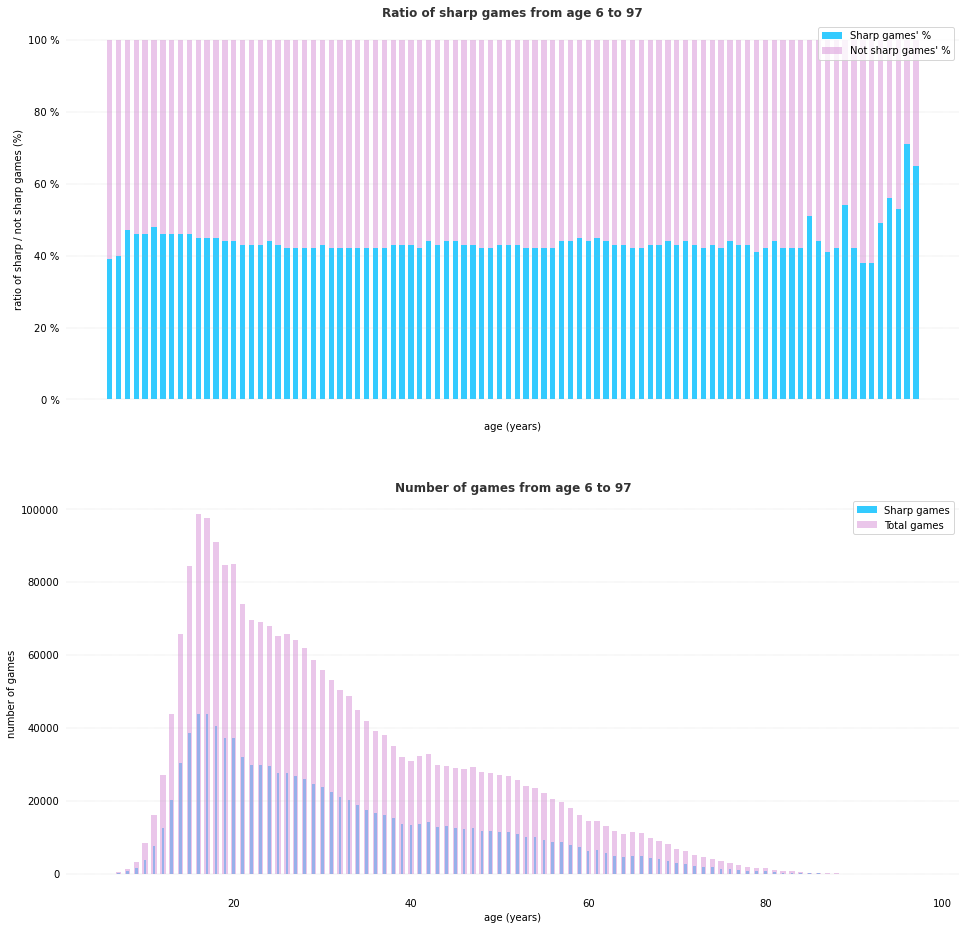

In [79]:
#displaying on stack column chart

source = age_variation[['age_at_game','sharp_ratio','not_sharp_ratio','total_sharp','total' ]].sort_values('age_at_game')
years = source['age_at_game']
sharp = source['sharp_ratio']
not_sharp = source['not_sharp_ratio']

total_sharp = source['total_sharp']
total = source['total'] # - source['total_sharp']

bar_width = 0.6
fig, axs = plt.subplots(2, 1, figsize=(16,16), sharex=True)
axs[0].bar(years, sharp, bar_width, label = "Sharp games' %", color='deepskyblue', alpha=0.8)
axs[0].bar(years, not_sharp, bar_width,bottom=sharp, label = "Not sharp games' %", color='plum', alpha=0.6)
axs[0].legend(frameon=True)
axs[0].set_xlabel('age (years)')
axs[0].set_ylabel('ratio of sharp / not sharp games (%)')
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(percent_format_func))
axs[0].grid(axis='y', linestyle='dotted', linewidth = 0.4)
axs[0].use_sticky_edges = False
axs[0].spines['top'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].tick_params(bottom=False, left=False)
axs[0].set_title('Ratio of sharp games from age {} to {}'.format(years.min(), years.max()), pad=5, color='#333333',
             weight='bold')

axs[1].bar(years, total_sharp, bar_width/2, label = "Sharp games", color='deepskyblue', alpha=0.8)
axs[1].bar(years, total, bar_width,bottom=0, label = "Total games", color='plum', alpha=0.6)
axs[1].legend(frameon=True)
axs[1].set_xlabel('age (years)')
axs[1].set_ylabel('number of games')
axs[1].grid(axis='y', linestyle='dotted', linewidth = 0.4)
axs[1].use_sticky_edges = False
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].tick_params(bottom=False, left=False)
axs[1].set_title('Number of games from age {} to {}'.format(years.min(), years.max()), pad=5, color='#333333',
             weight='bold')



## Question 2 - location style differences
this section filters players for country only, not filtering on age, number of games etc, the only requirement is that a game has to have a known player

creating 2 dataframes, one for country - year grouping and one for country only

In [80]:
# the dataframe for country comparisons will need to have the country column filled, 
# this will unfortunately seriously decrease the available data
# moreover for reasonable data it needs to be filtered for minimum games

country_data = games_merged_for_id_year_player[ games_merged_for_id_year_player['country'].notnull() ][['sharp_white', 'sharp_black', 'total_white', 'total_black','country']]
country_data = country_data.groupby(['country'], sort=False).apply(game_grouping)
add_totals(country_data)
country_data.reset_index(inplace = True)
country_data = country_data[country_data['total'] > minimum_games_country]
country_data

,country,sharp_white,total_white,sharp_black,total_black,total_sharp,total,sharp_ratio,not_sharp_ratio
0,RUS,47604.0,126682.0,58515.0,126134.0,106119.0,252816.0,0.42,0.58
1,ARG,7048.0,16428.0,8462.0,16341.0,15510.0,32769.0,0.47,0.53
2,IND,20711.0,54568.0,24478.0,54268.0,45189.0,108836.0,0.42,0.58
3,UZB,2567.0,6612.0,2919.0,6590.0,5486.0,13202.0,0.42,0.58
4,URS,11298.0,35271.0,16863.0,34972.0,28161.0,70243.0,0.40,0.60
...,...,...,...,...,...,...,...,...,...
190,SGP,63.0,115.0,64.0,118.0,127.0,233.0,0.55,0.45
191,LAO,27.0,63.0,26.0,67.0,53.0,130.0,0.41,0.59
192,PAK,70.0,239.0,104.0,241.0,174.0,480.0,0.36,0.64
193,LBN,79.0,179.0,92.0,185.0,171.0,364.0,0.47,0.53


In [81]:
#loading country code list, removing unneeded columns and merge it based on country code / alpha 3 iso code
country_list = load_country_list()
country_data= country_data.merge(country_list, on='country', how='left')
country_data.sort_values('sharp_ratio', ascending = False)


/var/folders/1x/zcg8y_kn483f7n01d887r4t80000gp/T/ipykernel_64667/3672273111.py:12: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  country_list = loadfile(fn)


,country,sharp_white,total_white,sharp_black,total_black,total_sharp,total,sharp_ratio,not_sharp_ratio,name,Map_country
168,GCI,82.0,178.0,136.0,191.0,218.0,369.0,0.59,0.41,Guernsey,Guernsey
84,MYN,42.0,69.0,40.0,73.0,82.0,142.0,0.58,0.42,Myanmar,Myanmar
176,BDI,60.0,120.0,74.0,117.0,134.0,237.0,0.57,0.43,Burundi,Burundi
130,ESA,269.0,528.0,330.0,524.0,599.0,1052.0,0.57,0.43,El Salvador,El Salvador
97,ANT,15.0,27.0,14.0,25.0,29.0,52.0,0.56,0.44,Antigua and Barbuda,Antigua and Barbuda
...,...,...,...,...,...,...,...,...,...,...,...
187,PAK,70.0,239.0,104.0,241.0,174.0,480.0,0.36,0.64,Pakistan,Pakistan
179,STP,35.0,98.0,34.0,99.0,69.0,197.0,0.35,0.65,São Tomé and Príncipe,São Tomé and Príncipe
158,MNC,295.0,897.0,318.0,852.0,613.0,1749.0,0.35,0.65,Monaco,Monaco
93,ISV,9.0,46.0,20.0,46.0,29.0,92.0,0.32,0.68,United States Virgin Islands,United States Virgin Islands


,sharp_ratio,name
168,0.59,Guernsey
84,0.58,Myanmar
176,0.57,Burundi
130,0.57,El Salvador
97,0.56,Antigua and Barbuda
185,0.55,Singapore
162,0.55,Jersey
120,0.54,Liechtenstein
151,0.54,Jordan
155,0.53,Oman


None


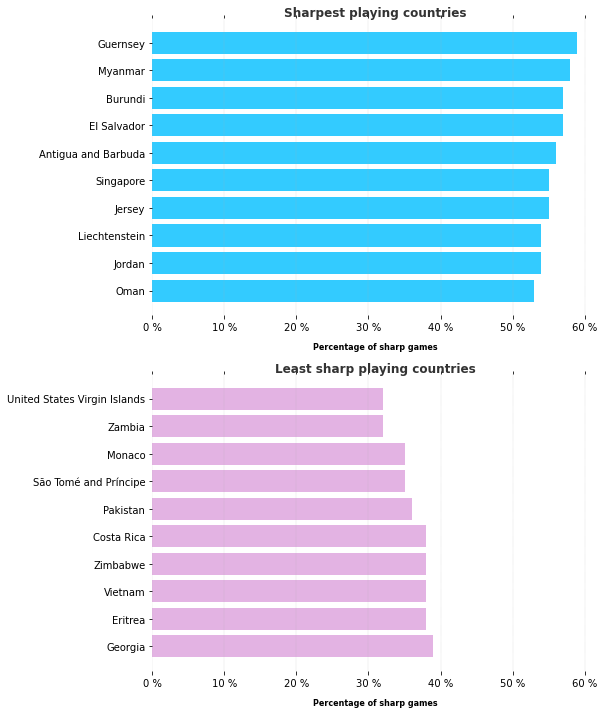

In [82]:
#displaying the 10-15 countries with the sharpest style... and the top 10-15 least sharp

country_top = country_data[['sharp_ratio','name']].sort_values('sharp_ratio',ascending = False).head(10)
print(display(country_top))
fig, axs = plt.subplots(2, 1, figsize=(8,12), sharex=True)
axs[0].barh(country_top['name'], country_top['sharp_ratio'],0.8,  label = "Sharp games' %", color='deepskyblue', alpha=0.8)
axs[0].invert_yaxis()
axs[0].xaxis.set_major_formatter(plt.FuncFormatter(percent_format_func))
axs[0].set_xlabel("Percentage of sharp games", labelpad=10, weight='bold', size=8)
axs[0].grid(axis='x', linestyle='dotted', linewidth = 0.4)
axs[0].use_sticky_edges = False
axs[0].spines['top'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].set_title('Sharpest playing countries', pad=2, color='#333333',weight='bold')
axs[0].tick_params(axis="x", which="major", bottom="off", top="off", labelbottom="on", left="off", right="on", labelleft="on")


country_bottom = country_data[['sharp_ratio','name']].sort_values('sharp_ratio').head(10)
axs[1].barh(country_bottom['name'], country_bottom['sharp_ratio'],0.8,  label = "Sharp games' %", color='plum', alpha=0.8)
axs[1].invert_yaxis()
axs[1].xaxis.set_major_formatter(plt.FuncFormatter(percent_format_func))
axs[1].set_xlabel("Percentage of sharp games", labelpad=10, weight='bold', size=8)
axs[1].grid(axis='x', linestyle='dotted', linewidth = 0.4)
axs[1].use_sticky_edges = False
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_title('Least sharp playing countries', pad=2, color='#333333',weight='bold')
axs[1].tick_params(axis="x", which="major", bottom="off", top="off", labelbottom="on", left="off", right="on", labelleft="on")



In [83]:
#map display to see if there is any geographical centre / correlation 
#each country is classified into one of 5 bands based equal distribution of min / max of country values
max_sharpness = country_data['sharp_ratio'].max()
min_sharpness = country_data['sharp_ratio'].min()
print('ranges is: {} to {}'.format(str(min_sharpness), str(max_sharpness)))

if max_sharpness > min_sharpness:
    #creating five bins dynamically and bin the countries based on these 
    bin_labels = [1,2,3,4,5]
    bin_size = (max_sharpness - min_sharpness) / 5

    bins = []
    for i in range(6):
        bins.append( round(min_sharpness + i*bin_size,2) )

    print('bin size' + str(bin_size))
    print(bins)
    
    #classify - bin countries
    country_data['category'] = pd.cut(country_data['sharp_ratio'], bins = bins, labels = bin_labels )    
else:
    country_data['category'] = 3
    print('cannot classify, not large enough range, setting all countries to 3')

ranges is: 0.32 to 0.59
bin size0.05399999999999999
[0.32, 0.37, 0.43, 0.48, 0.54, 0.59]


In [84]:
#displaying data - contains bin / category as well now
country_data.head()

,country,sharp_white,total_white,sharp_black,total_black,total_sharp,total,sharp_ratio,not_sharp_ratio,name,Map_country,category
0,RUS,47604.0,126682.0,58515.0,126134.0,106119.0,252816.0,0.42,0.58,Russian Federation,Russia,2
1,ARG,7048.0,16428.0,8462.0,16341.0,15510.0,32769.0,0.47,0.53,Argentina,Argentina,3
2,IND,20711.0,54568.0,24478.0,54268.0,45189.0,108836.0,0.42,0.58,India,India,2
3,UZB,2567.0,6612.0,2919.0,6590.0,5486.0,13202.0,0.42,0.58,Uzbekistan,Uzbekistan,2
4,URS,11298.0,35271.0,16863.0,34972.0,28161.0,70243.0,0.40,0.60,Soviet Union,Soviet Union,2


Text(0.5, 1.0, "Countries vs their players' sharp chess opening selection")

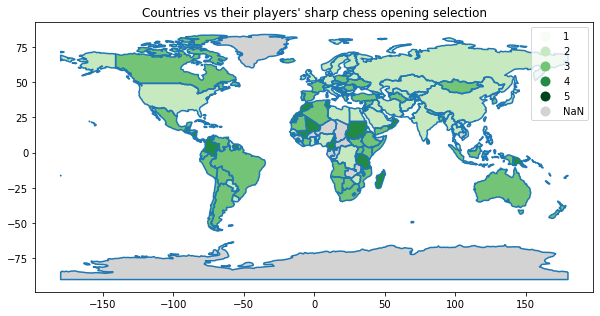

In [85]:
#dispalying categories on map
import geopandas as gpd
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


ax = df_world['geometry'].boundary.plot(figsize=(10,6))
df_world_countries = df_world.merge(country_data, how='left', left_on='name', right_on='Map_country' )
df_world_countries.plot( column='category', ax=ax, cmap='Greens', 
                     legend=True, missing_kwds={'color': 'lightgrey'})
ax.set_title('Countries vs their players\' sharp chess opening selection')